### Tutorial \#9 
Computer- and robot-assisted surgery
## Registration
&copy; Micha Pfeiffer, National Center for Tumor Diseases (NCT) Dresden

## Preperation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import math
from scipy.spatial.transform import Rotation

We'll frequently need to apply a rotation R and translation t to a point cloud, so let's define a helper function for this:

In [2]:
def apply_transform( points: np.ndarray, R: np.ndarray, t: np.ndarray ):
    """ Applies the rotation matrix R and translation vector t to the points
    
    Args:
        points: Numpy array, shape (N,3)
        R: Numpy array (matrix) of shape (3,3)
        t: Numpy array (vector) of shape (3)
    
    Returns:
        R*points + t
    """
    #print(R.shape, points.shape, t.shape)
    # This computes R*points + t. The "transposes" are just there to flip from row-of-points to column-of-points and vice versa:
    return (R @ points.transpose()).transpose() + t

We'll also regularly want to visualize source and target point clouds, so let's write a function to plot them:

In [3]:
def plot_points( source, target ):
    """ Show source and target point clouds
    
    Args:
        source: numpy.ndarray of dtype float with shape (N, 3)
        target: numpy.ndarray of dtype float with shape (M, 3)
    """
    fig = plt.figure( figsize=(7,6) )
    ax = fig.add_subplot( projection='3d' )
    # Draw the source points:
    ax.scatter( source[:,0], source[:,1], source[:,2], color="red" )
    # Draw the target points:
    ax.scatter( target[:,0], target[:,1], target[:,2], color="blue" )

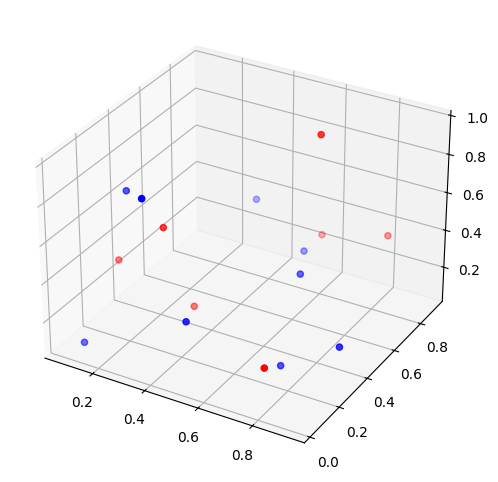

In [4]:
# Test plot points:
plot_points( np.random.rand( 7,3 ), np.random.rand( 9, 3 ) )

## <center><font>Feature-Based Registration</font></center>

Imagine we have two point clouds and some algorithm (for example a deep neural network) has computed features for the points and determined which of these features (i.e. which of the points) match, or correspond to each other. This means we're left with N source points P and the N matching target points Q and we are looking for an transformation T that best transforms P onto Q:
    
    T(P) = Q
    
For now, let us only consider rigid transformations T, meaning they are only made up of a rotation R and translation t (no shear, no scaling, no deformation). This is used, for example, when registering two different scans of the same bone onto each other.
Since the data is usually noisy, there is no R and t that works for all of P's points at once, so the equation usually has no solution.
Instead, we will try to find a solution that works best for all points, i.e. we want to minimize the error E:

    E = Q - T(P)
    
This can be formulated as a least-squares problem:

    Find T that minimizes: || Q - T(P) ||^2
    
A possible mathematical solution of this problem (based on the singular value decomposition (SVD)) was given in [Least-Squares Fitting of Two 3-D Point Sets. Arun et al. 1987](https://www.ece.queensu.ca/people/S-D-Blostein/papers/PAMI-3DLS-1987.pdf) and is summarized in the following slide of the lecture:

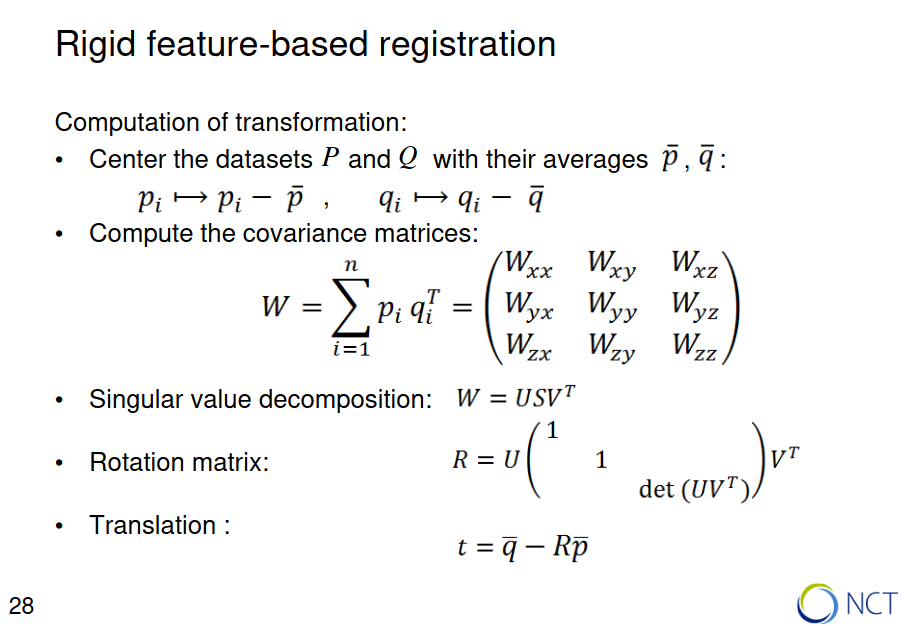

Let's write a function which performs this calculation:

In [5]:
def compute_transform( source: np.ndarray, target: np.ndarray ):
    """ Calculate transformation that moves "points_source" to "points_target"
    
    Given two arrays of corresponding points, calculate a transformation that,
    when applied to points_source will move them onto points_target.
    
    Note: This function expects the first point in source to correspond to the
    first point in target and so on.
    
    Args:
        points_source: Array of shape (N, 3)
        points_target: Array of the same shape
    """
    assert source.shape == target.shape
    assert source.ndim == 2
    assert source.shape[1] == 3  # 3D
    assert source.shape[0] > 3   # At least 4 correspondences
    
    source_mean = source.mean(axis=0)
    target_mean = target.mean(axis=0)
    
    src = source - source_mean
    tgt = target - target_mean
    
    #H = np.matmul(tgt.transpose(), src)
    H = tgt.transpose() @ src
    
    # Perform singular value decomposition:
    U, S, Vt = np.linalg.svd(H)
    # Test that U*S*Vt is indeed H:
    #np.testing.assert_allclose( H, U @ np.diag(S) @ Vt )
    
    # Calculate rotation:
    d = np.linalg.det( U @ Vt )
    D = np.diag((1,1,d))
    # TODO: Calculate rotation matrix R:
    R = U @ D @ Vt
    
    # There may be cases where the calculated R is a reflection of what we
    # actually want (see Arun et al. paper). This is true when the
    # determinant is 1, and can be resolved by negating the last value
    # of Vt:
    if np.linalg.det(R) < 0:
        Vt[:,-1] *= -1
        # (Or Vt[-1,:] *= -1?) Note: I didn't test with a case where this
        # branch is executed.
        R = U @ D @ Vt
    
    # Calculate translation:
    t = target_mean - (R @ source_mean)
    
    return R, t


Now let's test this function. For this, we'll create some random point clouds:

In [6]:
# Define some target points:
target_rnd = np.random.rand( 4, 3 )
# As a sanity check, let's try to register the exact same points to the target:
source_rnd = target_rnd.copy()
#source_rnd[:,0] += 0.01
# Compute the transform: 
R, t = compute_transform( source_rnd, target_rnd )

# Note how the rotation is almost the Identity matrix (= no rotation) and the translation is almost zero:
print("Rotation:", R)
print("Translation:", t)

Rotation: [[ 1.00000000e+00 -1.19634258e-15 -1.94409368e-15]
 [ 1.28492121e-15  1.00000000e+00 -8.00358477e-16]
 [ 1.97064587e-15  1.02695630e-15  1.00000000e+00]]
Translation: [ 1.77635684e-15  1.11022302e-16 -1.44328993e-15]


At this point we can also perform a sanity-check for the apply_transform function: Applying the identitiy transform we just computed to the source should yield the same point cloud as the target, because source and target are already the same:

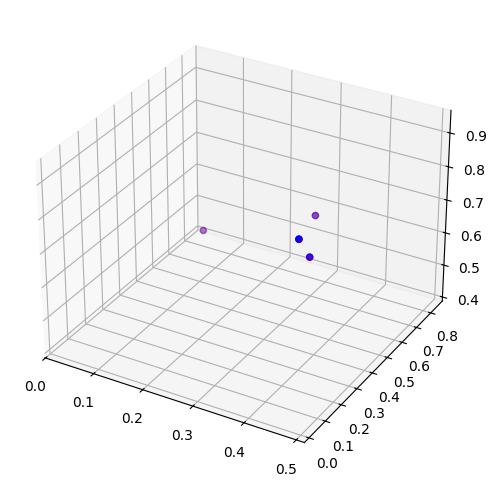

In [7]:
# Apply the transformation to the source points:
aligned = apply_transform( source_rnd, R, t )
# Make sure the aligned points are close to the target:
np.testing.assert_allclose( aligned, target_rnd ) # This will throw an error if the two arguments are not very similar

# Plot to see closeness
plot_points( aligned, target_rnd )

Let's try again, this time we'll offset all source points by a common vector `offset` and add a bit of individual noise to each point.

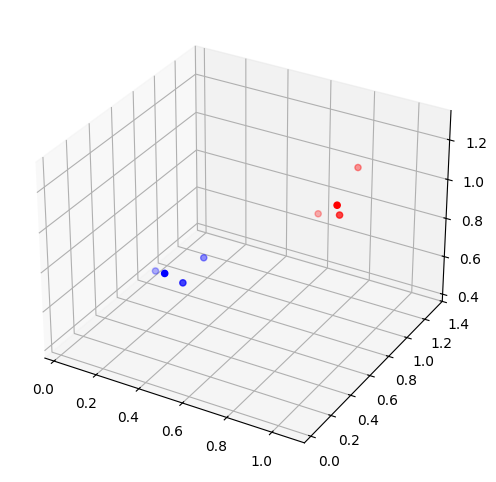

In [8]:
# Random (3x1) vector:
offset = np.random.rand( 3 )
# Apply a bit of individual noise to each point:
noise = 0.2*np.random.rand( *target_rnd.shape )
source_offset = target_rnd.copy() + offset + noise

# Show source and target:
plot_points( source_offset, target_rnd )

**Before running the following code, it may be good to stop and think about what you expect!**

Rotation: [[ 0.91431187  0.14775316  0.37709787]
 [-0.22056958  0.96254609  0.15765179]
 [-0.33968053 -0.22731923  0.91265717]]
Translation: [-0.99745899 -0.34802241  0.23019875]


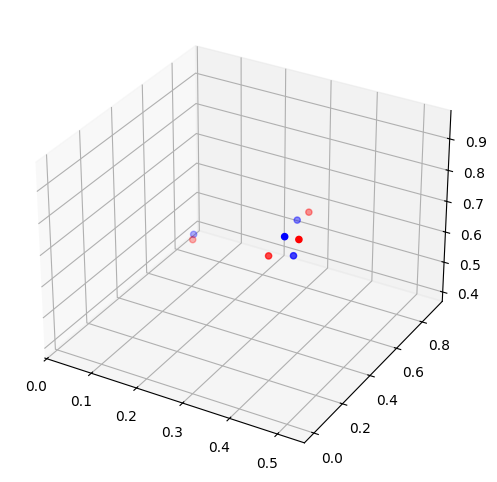

In [9]:
# Compute the transform:
R, t = compute_transform( source_offset, target_rnd )

# Note how the rotation is almost the Identity matrix (= no rotation) and the translation is almost zero:
print("Rotation:", R)
print("Translation:", t)

aligned = apply_transform( source_offset, R, t )

# Show result and target:
plot_points( aligned, target_rnd )

In practice, finding many reliable correspondences is often difficult. What if we still want to register two point clouds that have a similar shape?

## Registration Algorithm: Iterative Closest Point (ICP)

There are many versions of the ICP algorithm. In its essential form, the algorithm does the following:
Given a source and a target point cloud (where no correspondences are known and the number of points may differ), compute a rigid transformation that aligns the source with the target by carrying out the following steps:
1. For each source point, find the nearest target point. These will be considered "correspondences" for this iteration
2. Estimate rotation and translation to best align the source points to these estimated corresponding target points
3. Apply the rotation and translation to the source points. Then go back to step 1 until some stopping criterium is met.

For ICP, the correspondences change each iteration. That's why it's helpful if we can visualize these correspondences. So before we start, we'll define a new helper function. In its basic form, it simply plots the two given point clouds. When given the optional `target_indices`, it will additionally plot lines between each source point and its target correspondences:

In [27]:
def plot_points_and_correspondences( source, target, target_indices=None ):
    """ Show source and target point clouds (and optionally show correspondences):
    
    Args:
        source: numpy.ndarray of dtype float with shape (N, 3)
        target: numpy.ndarray of dtype float with shape (M, 3)
        target_indices: numpy.ndarray of dtype int with shape (N)
    """
    
    plt.clf()
    fig = plt.figure( figsize=(7,6) )
    ax = fig.add_subplot( projection='3d' )
    
    # Draw the source points:
    ax.scatter( source[:,0], source[:,1], source[:,2], color="red" )
    # Draw the target points:
    ax.scatter( target[:,0], target[:,1], target[:,2], color="blue" )
    
    # If the indices of the target points which correspond to the source
    # points are known (or have been estimated), draw lines from each
    # source point to the nearest target point:
    if target_indices is not None:
        N_source = source.shape[0]
        for i in range( N_source ):
            source_point = source[i,:]
            target_index = target_indices[i]
            target_point = target[target_index,:]
            #print(source_point, "->", target_point)
            ax.plot( [source_point[0], target_point[0]],
                    [source_point[1], target_point[1]],
                    [source_point[2], target_point[2]], color="grey" )

For the ICP algorithm, we'll need to find the closest target point for each source point. Let's write a function for this! Note: There are multiple solutions, some more efficient than others. For an efficient solution, you could look at KD trees.

In [11]:
def find_closest_points( source, target ):
    """ Find the closest target point for each source point
    
    You can use a brute-force solution (comparing all pairwise distances between points) or use a "smarter" KD tree (maybe
    scipy.spatial.KDTree ?) to find nearest neighbors.
    
    Args:
        source: numpy.ndarray of dtype float with shape (N, 3)
        target: numpy.ndarray of dtype float with shape (M, 3)
    Returns:
        closest_points: numpy.ndarray of dtype float with shape (N,3)
        indices: numpy array (int) with shape (N)
    """
    
    # For each source point, find the indices of the closest target points
    indices = list(range(len(target)))
    
    for si, point in enumerate(source):
        indices[si] = np.argmin(np.linalg.norm(target[indices] - point, axis=1))
    
    # Return those closest points, but also the indices in case they're needed again:
    closest_points = target.copy()[indices]
    return closest_points, indices

Let's start with some dummy data and test our `find_closest_points` method:

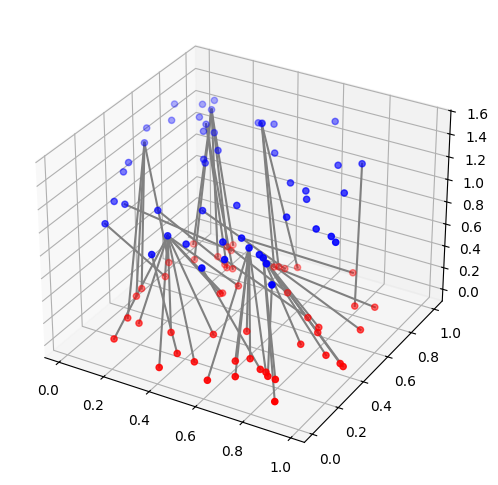

In [12]:
# Define some new target points:
N_points = 50
points = np.random.rand( N_points, 3 )
points[:,2] = 0 # move all Z-values onto same height -> these points describe a plane!

# Next, to test registration, we'll rotate these target points slightly. For this, create a
# rotation matrix around the z axis:
ang = 30
R = Rotation.from_euler('x', ang, degrees=True).as_matrix()
# We'lll also define a translation vector to move the points upwards (along the z axis):
t = np.asarray([0,0,1])

# Now apply these to the points, which will give us our target point cloud:
target = apply_transform( points, R, t )

# As source points, use the original plain...
source = points.copy()
# ... but let's add a bit of noise to simulate that it was taken from a different sensor:
source += 0.03*np.random.rand( *source.shape )

# Now, test the finding of closest points:
closest_target_points, closest_target_point_indices = find_closest_points( source, target )
#print(source - closest_target_points)
plot_points_and_correspondences( source, target, closest_target_point_indices )
# plot_points_and_correspondences( source, closest_target_points )

Now, ICP is actually pretty easy:

In [32]:
from IPython.display import clear_output, display

def ICP( source, target, verbose=True, max_iterations = 15, show_all_steps=True ):
    
    # Let's record the error over time:
    errors = []
    
    for _ in range(max_iterations):
        # Each iteration, start by finding the target points closest to the source points:
        closest_target_points, indices = find_closest_points(source, target)
        
        # Check the remaining "error":
        # This simply uses the eucledian distance between each source point and its
        # closest target point:
        distances = np.sqrt( np.sum( (closest_target_points - source)**2, axis=1 ) )
        avg_dist = np.mean( distances )
        if verbose:
            print( "Average distance:", avg_dist )
        
        if show_all_steps:
            clear_output(wait=True)
            plot_points_and_correspondences(source, target, indices)
            display(plt.gcf())
        
        # Find the transform R and t which registers source to the closest_target_points:
        R, t = compute_transform(source, closest_target_points)
        
        # Then apply this transform:
        result = apply_transform(source, R, t)
        
        errors.append(avg_dist)
        
        # TODO (Bonus): We could implement an early abort if the avg_dist becomes low enough
        # or if there is no longer any meaningful change in avg_dist (i.e. we've found a
        # convergence point). In these cases, use 'break' to stop the loop.
        
        # For the next loop, we'll set "source" to be the previous "result":
        source = result
    
    # Plot result:
    if verbose:        
        plt.clf()
        plt.plot([i for i in range(len(errors))], errors)
        plt.xlabel( "iteration" )
        plt.ylabel( "average point dist" )
    
    # Return the transformed point cloud and the final distance:
    return source, errors[-1]

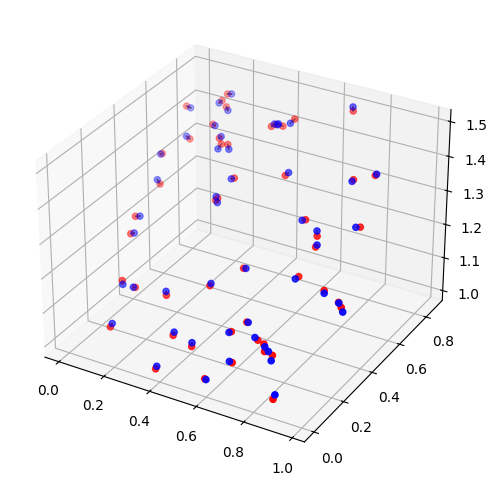

<Figure size 640x480 with 0 Axes>

<Figure size 700x600 with 0 Axes>

<Figure size 700x600 with 0 Axes>

<Figure size 700x600 with 0 Axes>

<Figure size 700x600 with 0 Axes>

<Figure size 700x600 with 0 Axes>

<Figure size 700x600 with 0 Axes>

<Figure size 700x600 with 0 Axes>

<Figure size 700x600 with 0 Axes>

<Figure size 700x600 with 0 Axes>

<Figure size 700x600 with 0 Axes>

<Figure size 700x600 with 0 Axes>

<Figure size 700x600 with 0 Axes>

<Figure size 700x600 with 0 Axes>

<Figure size 700x600 with 0 Axes>

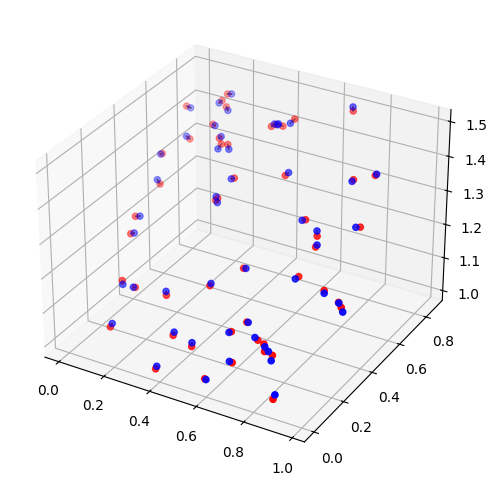

In [33]:
# let's try it out!
result, final_dist = ICP(source, target, verbose=False)

## <center><font color=navy>Rigid Liver Registration</font></center>

Now that ICP works with random points, let's try to register a two versions of a patient's liver to each other. First, we'll load the target liver shape:

Let's get some real liver data:

In [109]:
import urllib.request
from os.path import basename, exists
import zipfile

def download_and_extract(url): #download and extract Zip archive
    file_path = basename(url)
    if not exists(file_path): # does zip file already exist?
        urllib.request.urlretrieve(url, file_path) # if not, download it
        with zipfile.ZipFile(file_path, 'r') as zip_ref: # and unzip it
            zip_ref.extractall(".")

Next, let's load the Data. ".stl" files are simple 3D meshes with points and faces (surfaces), but we won't be needing the faces for this exercise, so we can load the meshes and only keep the points. Meshes which come from CT scans often also have a lot more points than necessary, for this exercise we'll randomly subsample the point clouds.

In [ ]:
import stl

def load_points( filename ):
    # Load the source liver:
    mesh = stl.mesh.Mesh.from_file( filename )
    # Let's only keep the points (and ignore the faces/normals etc):
    all_points = mesh.v0
    n_all_points = all_points.shape[0]
    # Also, let's take a random sub-set of the points to speed up
    # computation (not necessary):
    idx = np.random.randint(n_all_points, size=min(n_all_points, 1500))
    pts = all_points[idx,:]
    return pts

# Load a source mesh (that we will use for multiple experiments).
# This is a mesh extracted from a CT scan (and cleaned up a bit):
liver_source = load_points( "Exercise9/Liver_Source.stl" )

# Load a first test target mesh. This is the same liver from the 
# same patient:
liver_target_01 = load_points( "Exercise9/Liver_Target_01.stl" )

# Plot the livers!
plot_points_and_correspondences( liver_source, liver_target_01 )

As you can see, the two livers lie relatively close to each other, and there's no rotation between them. Let's try ICP!

In [ ]:
result, final_dist = ICP( liver_source, liver_target_01, max_iterations=25, show_all_steps=False )

There is still a residual error, even though the liver shapes we used are the same, just translated. Why do you think this is?

Next, we'll try a new target, that is rotated a bit.

In [ ]:
# Target with small rotation from the source:
liver_target_02 = load_points( "Exercise9/Liver_Target_02.stl" )

# Plot the livers!
plot_points_and_correspondences( liver_source, liver_target_02 )

 Again, let's use ICP to register the source to the target. Before running the following code, maybe you can make a prediciton what will happen?

In [ ]:
result, final_dist = ICP( liver_source, liver_target_02, show_all_steps=False )

Next, we'll try with a target with a large rotation:

In [ ]:
# Target with large rotation from the source
liver_target_03 = load_points( "Exercise9/Liver_Target_03.stl" )

# Plot the livers!
plot_points_and_correspondences( liver_source, liver_target_03 )

In [ ]:
result, final_dist = ICP( liver_source, liver_target_03,show_all_steps=False )

The result is not good (even if you drastically increase the number of iterations). ICP reaches a local minimum and cannot get back out. **What would be a solution to this problem?**

In [ ]:
import random

def ModifiedICP( source, target, num_trials=30 ):
    
    best_result = None
    lowest_avg_dist = np.inf
    
    for i in range(num_trials):
        
        # TODO
        
        
    print("Best result found:")
    plot_points_and_correspondences( best_result, target )
        

In [ ]:
ModifiedICP( liver_source, liver_target_03 )

The random nature of how we pick rotation axis means that results may vary between runs. In the best case, with the supplied liver data, you should get an average residual error around 4.9 mm. If your error remains much higher, you can try re-running the previous code segment.

Finally, let's get to a case where we only see a part of the liver surface, and this liver surface is deformed (when compared to the source mesh). Now, we've reached a case that is very close to the clinical reality: We have a CT scan of the liver (the source) and a partial point cloud of the intraoperative, deformed liver (the target). This partial point cloud could have been recorded with a stereo-camera or with some other depth-sensing device. Our goal is to align the preoperative CT scan liver with the intraoperative target (because we want to, for example, show a tumor that is visible in the CT scan but not in the intraoperative view).

In [ ]:
liver_target_04 = load_points( "Exercise9/Liver_Target_04_deformed_partial.stl" )

# Plot the livers
plot_points_and_correspondences( liver_source, liver_target_04 )

In [ ]:
ModifiedICP( liver_source, liver_target_04, num_trials=200 )

Even with many trials, this often does not converge to a good solution. Any ideas for solutions?

Hint: You can try to visualize every step of the ICP using `show_all_steps=True` and follow what happens, that might give you an idea.

In [ ]:
# Your solution here: